In [8]:
# Imports
import rdams_client as rc
import time
import numpy as np
import xarray as xr

In [9]:
def check_ready(rqst_id, wait_interval=120):
    """Checks if a request is ready."""
    for i in range(100): # 100 is arbitrary. Would wait 200 minutes for request
        res = rc.get_status(rqst_id)
        request_status = res['result']['status']
        if request_status == 'Completed':
            return True
        print(request_status)
        print('Not yet available. Waiting ' + str(wait_interval) + ' seconds.' )
        time.sleep(wait_interval)
    return False

In [10]:
download_id = '622638'

res = rc.get_status(download_id)
print(res)
info = res['result']['subset_info']['note']
which_year = info.split('Start date: ')[1][:4]

print(which_year)

Enter your RDA username or email:  tylersc@ucar.edu
Enter your RDA password:  ···········


{'status': 'ok', 'code': 200, 'messages': [], 'result': {'date_rqst': '2023-03-06', 'date_ready': '2023-03-06', 'date_purge': '2023-03-11', 'status': 'Completed', 'rinfo': 'gui=yes;dsnum=628.0;startdate=2022-01-01 00:00;enddate=2022-12-31 18:00;parameters=1!34-241.200:7,1!34-241.200:51,1!34-241.200:11,1!34-241.200:34;ofmt=netCDF;tindex=8', 'request_id': 'COX622638', 'NCAR_contact': 'davestep@ucar.edu', 'subset_info': {'note': '- Output format: netCDF\n- Start date: 2022-01-01 00:00\n- End date: 2022-12-31 18:00\n- Parameter(s):\n    Geopotential height\n    Specific humidity\n    v-component of wind\n    Temperature\n'}, 'request_index': '622638'}, 'request_start': '2023-03-06T12:28:51.641527', 'request_end': '2023-03-06T12:28:51.731311', 'request_duration': '0.089784 seconds'}
2022


In [6]:
res

{'status': 'error',
 'code': 421,
 'messages': ['Request Index not found for email.',
  'email: apache@ucar.edu, request index: 622638'],
 'result': {},
 'request_start': '2023-03-06T12:08:10.459498',
 'request_end': '2023-03-06T12:08:10.546445',
 'request_duration': '0.086947 seconds'}

In [6]:
check_ready(download_id)
#rc.download(download_id)

KeyError: 'status'

In [4]:

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

if int(which_year) % 4 == 0:
    #This is a leap year
    months_ends = ['0131', '0229', '0331', '0430', '0531', '0630',
                   '0731', '0831', '0930', '1031', '1130', '1231']
else:
    months_ends = ['0131', '0228', '0331', '0430', '0531', '0630',
                   '0731', '0831', '0930', '1031', '1130', '1231']

In [5]:
for idx, month in enumerate(months):
    file_names = 'anl_p125.*.' + which_year + month + '0100_' + which_year + months_ends[idx] + '18.cox' + download_id + '.nc'
    ds = xr.open_mfdataset(file_names)

    ds = ds.rename({'lv_ISBL1':'lev',
                    'initial_time0_hours':'time',
                    'g0_lat_2':'lat',
                    'g0_lon_3':'lon',
                    'HGT_GDS0_ISBL':'height',
                    'SPFH_GDS0_ISBL':'q',
                    'TMP_GDS0_ISBL':'temp',
                    'VGRD_GDS0_ISBL':'vcomp'})
    
    ds['vq'] = ds.vcomp * ds.q
    ds['vt'] = ds.vcomp * ds.temp
    ds['vz'] = ds.vcomp * ds.height
    
    ds = ds.drop('initial_time0_encoded')
    ds_mean = ds.mean('time')
    
    month_time = [np.datetime64(which_year + '-' + month + '-01')]

    #print(test_time)
    ds_mean_time = ds_mean.expand_dims(dim={'time':month_time}, axis=0)
    
    ds_mean_time.to_netcdf('raw_data/jra_' + which_year + '_' + month + '.nc')

/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

In [9]:
test = xr.open_mfdataset('raw_monthly_data/jra_1959*')

test

<xarray.Dataset>
Dimensions:  (time: 12, lev: 37, lat: 145, lon: 288)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 1959-12-01
  * lev      (lev) int32 1 2 3 5 7 10 20 30 ... 825 850 875 900 925 950 975 1000
  * lat      (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    height   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>
    q        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>
    temp     (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>
    vcomp    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>
    vq       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>
    vt       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>
    vz       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 37, 145, 288), meta=np.ndarray>

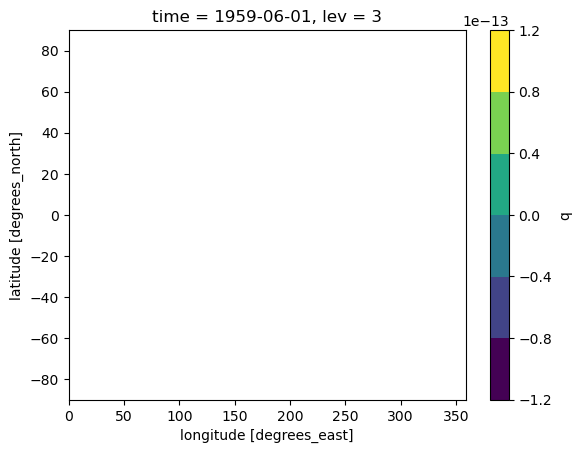

In [84]:
import matplotlib.pyplot as plt
new_test.q.sel(lev=3).isel(time=0).plot.contourf()

plt.show()

In [91]:
np.sum(np.isnan(test.q.sel(lev=70).values))

41760

In [93]:
np.sum(np.isnan(new_test.height.values))

0